In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [144]:
import os
import pandas as pd

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape, Layer, TimeDistributed, Concatenate, Lambda
from keras.datasets import mnist
from keras.utils import to_categorical

import keras.backend as K

from vae_utils import *

In [3]:
os.chdir('./data/iwae/')

# Data

In [4]:
def preprocess(data):
    x, y = data
    x = x.reshape((len(x), 28, 28))
    x = x/255.
    #y = to_categorical(y, 10) #don't need to categorise y
    return x, y

train, test = mnist.load_data()

x_train, y_train = preprocess(train)
x_test, y_test = preprocess(test)

print(x_train.shape)

(60000, 28, 28)


# Custom layers

In [185]:
# we need a layer that samples a latent variable given a mean and standard deviation

class Sampler(Layer):
    
    def __init__(self, **kwargs):
        self.stddev = 1
        super(Sampler, self).__init__(**kwargs)
    
    def call(self, x, training=None):
        assert isinstance(x, list)
        z_mean, log_z_var = x
        z_std = K.exp(log_z_var/2)
        # sample epsilon from N(0, stddev)
        shape = K.shape(z_std)
        epsilon = K.random_normal(shape, mean=0, stddev=self.stddev)
        # we sample during training only
        z_sample = z_mean + z_std * epsilon
        return K.in_train_phase(z_sample, z_mean, training=training)
    
    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        assert input_shape[0] == input_shape[1]
        return input_shape[0]

# Models

In [274]:
def encoder_1(k, latent_dim=100, hidden_dim=200):
    # shared layers
    hid_1 = Dense(hidden_dim, activation='tanh', name='enc_1_hidden_1')
    hid_2 = Dense(hidden_dim, activation='tanh', name='enc_1_hidden_2')
    z_mean = Dense(latent_dim, name='enc_1_latent_mean')
    log_z_var = Dense(latent_dim, name='enc_1_log_latent_var')
    
    # define time distributed model for training for k forward passes
    td_x = Input(shape=(k, 28, 28), name='td_enc_1_input')
    y = Reshape((k, 28*28), name='td_enc_1_flatten')(td_x)
    y = TimeDistributed(hid_1, name='td_enc_1_hidden_1')(y)
    y = TimeDistributed(hid_2, name='td_enc_1_hidden_2')(y)
    td_z_mean = TimeDistributed(z_mean, name='td_enc_1_latent_mean')(y)
    td_log_z_var = TimeDistributed(log_z_var, name='td_enc_1_log_latent_var')(y)
    
    td_model = Model(inputs=td_x, outputs=[td_z_mean, td_log_z_var], name='td_encoder_1')
    
    # define single forward pass model
    x = Input(shape=(28, 28), name='enc_1_input')
    y = Flatten(name='enc_1_flatten')(x)
    y = hid_1(y)
    y = hid_2(y)
    y = Sampler(name='encoder_1_sampler')([z_mean(y), log_z_var(y)])
    
    model = Model(inputs=x, outputs=y, name='encoder_1')
    td = TimeDistributed(model, name='td_enc_1')(td_x)
    td_model = Model(td_x, td, name='td_encoder_1')
    
    return td_model, model


def encoder_2(k, latent_dim=100, hidden_dim=100):
    # shared layers
    hid_1 = Dense(hidden_dim, activation='tanh', name='enc_2_hidden_1')
    hid_2 = Dense(hidden_dim, activation='tanh', name='enc_2_hidden_2')
    z_mean = Dense(latent_dim, name='enc_2_latent_mean')
    log_z_var = Dense(latent_dim, name='enc_2_log_latent_var')
    
    # define time distributed model for training for k forward passes
    td_x = Input(shape=(k, latent_dim), name='td_enc_2_input')
    y = TimeDistributed(hid_1, name='td_enc_2_hidden_1')(td_x)
    y = TimeDistributed(hid_2, name='td_enc_2_hidden_2')(y)
    td_z_mean = TimeDistributed(z_mean, name='td_enc_2_latent_mean')(y)
    td_log_z_var = TimeDistributed(log_z_var, name='td_enc_2_log_latent_var')(y)
    
    td_model = Model(inputs=td_x, outputs=[td_z_mean, td_log_z_var], name='td_encoder_2')
    
    # define single forward pass model
    x = Input(shape=(latent_dim,), name='enc_2_input')
    y = hid_1(x)
    y = hid_2(y)
    y = Sampler()([z_mean(y), log_z_var(y)])
    
    model = Model(inputs=x, outputs=y, name='encoder_2')
    td = TimeDistributed(model, name='td_enc_2')(td_x)
    td_model = Model(td_x, td, name='td_encoder_2')
    
    return td_model, model


def decoder_2(k, latent_dim=100, hidden_dim=100):
    # shared layers
    hid_1 = Dense(hidden_dim, activation='tanh', name='dec_2_hidden_1')
    hid_2 = Dense(hidden_dim, activation='tanh', name='dec_2_hidden_2')
    z_mean = Dense(latent_dim, name='dec_2_latent_mean')
    log_z_var = Dense(latent_dim, name='dec_2_log_latent_var')
    
    # define time distributed model for training for k forward passes
    td_x = Input(shape=(k, latent_dim), name='td_dec_2_input')
    y = TimeDistributed(hid_1, name='td_dec_2_hidden_1')(td_x)
    y = TimeDistributed(hid_2, name='td_dec_2_hidden_2')(y)
    td_z_mean = TimeDistributed(z_mean, name='td_dec_2_latent_mean')(y)
    td_log_z_var = TimeDistributed(log_z_var, name='td_dec_2_log_latent_var')(y)
    
    td_model = Model(inputs=td_x, outputs=[td_z_mean, td_log_z_var], name='td_decoder_2')
    
    # define single forward pass model
    x = Input(shape=(latent_dim,), name='dec_2_input')
    y = hid_1(x)
    y = hid_2(y)
    y = Sampler()([z_mean(y), log_z_var(y)])
    
    model = Model(inputs=x, outputs=y, name='decoder_2')
    td = TimeDistributed(model)(td_x)
    td_model = Model(td_x, td, name='td_decoder_2')
    
    return td_model, model


def decoder_1(k, latent_dim=100, hidden_dim=200):
    # shared layers
    hid_1 = Dense(hidden_dim, activation='tanh', name='dec_1_hidden_1')
    hid_2 = Dense(hidden_dim, activation='tanh', name='dec_1_hidden_2')
    bernoulli_mean = Dense(28*28, activation='sigmoid', name='dec_1_mean')
    
    # define time distributed model for training for k forward passes
    td_x = Input(shape=(k, latent_dim), name='td_dec_1_input')
    y = TimeDistributed(hid_1, name='td_dec_1_hidden_1')(td_x)
    y = TimeDistributed(hid_2, name='td_dec_1_hidden_2')(y)
    y = TimeDistributed(bernoulli_mean, name='td_dec_1_mean')(y)
    y = TimeDistributed(Reshape((28, 28), name='td_dec_1_output'))(y)
    
    td_model = Model(inputs=td_x, outputs=y, name='td_decoder_1')
    
    # define single forward pass model
    x = Input(shape=(latent_dim,), name='dec_1_input')
    y = hid_1(x)
    y = hid_2(y)
    y = bernoulli_mean(y)
    y = Reshape((28, 28), name='dec_1_output')(y)
    
    model = Model(inputs=x, outputs=y, name='decoder_1')
    td = TimeDistributed(model, name='td_dec_1')(td_x)
    td_model = Model(td_x, td, name='td_decoder_1')
    
    return td_model, model


def connect_enc_dec(encoder, decoder, name=None):
    if isinstance(encoder, list) and isinstance(decoder, list):
        x = Input(batch_shape = encoder[0].input_shape, name=encoder[0].name + '_input')
        z_mean, log_z_var = encoder[0](x)
        # connect encoders
        for i in range(len(encoder)-1):
            sampler, _ = Sampler(name=encoder[i].name + '_sampler')([z_mean, log_z_var])
            z_mean, log_z_var = encoder[i+1](sampler)
        # connect final encoder to decoder
        sampler = Sampler(name=encoder[-1].name + '_sampler')([z_mean, log_z_var])
        # connect decoders
        for i in range(len(decoder)-1):
            z_mean, log_z_var = decoder[i](sampler)
            sampler, _ = Sampler(name=decoder[i].name + '_sampler')([z_mean, log_z_var])
        # get the output
        out = decoder[-1](sampler)
        return Model(x, out)
    else:
        x = Input(batch_shape = encoder.input_shape, name=encoder.name + '_input')
        z_mean, log_z_var = encoder.outputs
        sampler = Sampler(name=encoder.name + '_sampler')([z_mean, log_z_var])
        return  Model(encoder.inputs, decoder(sampler), name=name)

In [275]:
def model_1(k):
    td_enc, enc = encoder_1(k)
    td_dec, dec = decoder_1(k)
    
    #td_model = connect_enc_dec(td_enc, td_dec, name='td_model_1')
    #model = connect_enc_dec(enc, dec, name='model_1')
    td_model = Model(td_enc.inputs, td_dec(td_enc.output))
    model = Model(enc.inputs, dec(enc.output))
    return [td_model, td_enc, td_dec], [model, enc, dec]

In [276]:
def model_2(k):
    td_enc_1, enc_1 = encoder_1(k)
    td_enc_2, enc_2 = encoder_2(k)
    td_dec_2, dec_2 = decoder_2(k)
    td_dec_1, dec_1 = decoder_1(k)
    
    td_model = connect_enc_dec([td_enc_1, td_enc_2], [td_dec_2, td_dec_1], name='td_model_2')
    model = connect_enc_dec([enc_1, enc_2], [dec_2, dec_1], name='td_model_2')
    return td_model, model

In [277]:
td_mod1, mod1 = model_1(5)
td_mod1.summary()

AttributeError: 'list' object has no attribute 'summary'

# Training Model 1

In [278]:
td_enc_1, enc_1 = encoder_1(k)
td_dec_1, dec_1 = decoder_1(k)

z_mean, log_z_var = td_enc_1.outputs
sampler = Sampler(name=td_enc_1.name + '_sampler')
batch = K.shape(z_mean)[0]
latent_dim = K.shape(z_mean)[-1]
td_samples = [sampler([z_mean[:, i, :], log_z_var[:, i, :]]) for i in range(k)]
td_samples = [K.reshape(sample, (batch, 1, 100)) for sample in td_samples]
td_samples = K.concatenate(td_samples, axis=1)
print(td_samples)

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
k = 5

(td_mod1, td_enc1, td_dec1), (mod1, enc1, dec1) = model_1(k)
td_enc1.summary()

# get sampling layers
h1_sample = td_enc1.get_layer('td_enc_1').output
h1_sample = sampler

# get mean / std values
z_mean = enc1.get_layer('enc_1_latent_mean').output
log_z_var = enc1.get_layer('enc_1_log_latent_var').output

def td_model_1_loss(y_true, y_pred):
    # calculate log distributions (log_p_x_y := p(x|y))
    log_q_h1_x = -0.5 * K.sum(log_z_var + K.exp(-log_z_var)*(h1_sample - z_mean)**2, axis=-1)
    log_p_h1 = -0.5 * K.sum(K.square(h1_sample), axis=-1)
    log_p_x_h1 = -K.sum(K.binary_crossentropy(y_true, y_pred), axis=(-1, -2))
    #log_p_x_h1 = K.sum(y_true * K.log(y_pred) + (1-y_true) * K.log(1-y_pred), axis=(-1, -2))
    
    # calculate real distributions
    q_h1_x = K.exp(log_q_h1_x)
    p_h1 = K.exp(log_p_h1)
    p_x_h1 = K.exp(log_p_x_h1)
        
    # calculate weights
    log_weights = log_p_x_h1 + log_p_h1 - log_q_h1_x
    #weights = K.softmax(log_weights, axis=1)
    #weights = K.constant(K.get_value(weights))
    #print(K.gradients(weights))
    
    # calculate loss
    elbo = log_p_x_h1 + log_p_h1 - log_q_h1_x
    elbo = K.mean(elbo, axis=1)
    loss = -elbo
    
    return elbo

td_mod1.compile(optimizer='adam', loss=td_model_1_loss)

td_x_train = expand_dims(x_train, axis=1)
td_x_train = repeat(td_x_train, k, axis=1)

td_mod1.fit(x=td_x_train, y=td_x_train, batch_size=512, epochs=1)

In [279]:
k = 5

(td_mod1, td_enc1, td_dec1), (mod1, enc1, dec1) = model_1(k)
mod1.summary()

# get sampling layers
h1_sample = mod1.get_layer('encoder_1_sampler').output

# get mean / std values
z_mean = mod1.get_layer('enc_1_latent_mean').output
log_z_var = mod1.get_layer('enc_1_log_latent_var').output

def model_1_loss(y_true, y_pred):
    # calculate log distributions (log_p_x_y := p(x|y))
    log_q_h1_x = -0.5 * K.sum(log_z_var + K.exp(-log_z_var)*(h1_sample - z_mean)**2, axis=-1)
    log_p_h1 = -0.5 * K.sum(K.square(h1_sample), axis=-1)
    log_p_x_h1 = -K.sum(K.binary_crossentropy(y_true, y_pred), axis=(-1, -2))
    #log_p_x_h1 = K.sum(y_true * K.log(y_pred) + (1-y_true) * K.log(1-y_pred), axis=(-1, -2))
        
    # calculate weights
    log_weights = log_p_x_h1 + log_p_h1 - log_q_h1_x
    #weights = K.softmax(log_weights, axis=1)
    #weights = K.constant(K.get_value(weights))
    #print(K.gradients(weights))
    
    # calculate loss
    #elbo = K.mean((log_p_x_h1 + log_p_h1 - log_q_h1_x), axis=1)
    elbo = log_p_x_h1 + log_p_h1 - log_q_h1_x
    loss = -elbo
        
    return loss

mod1.compile(optimizer='adam', loss=model_1_loss)

mod1.fit(x=x_train, y=x_train, batch_size=512, epochs=10)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_1_input (InputLayer)        (None, 28, 28)       0                                            
__________________________________________________________________________________________________
enc_1_flatten (Flatten)         (None, 784)          0           enc_1_input[0][0]                
__________________________________________________________________________________________________
enc_1_hidden_1 (Dense)          (None, 200)          157000      enc_1_flatten[0][0]              
__________________________________________________________________________________________________
enc_1_hidden_2 (Dense)          (None, 200)          40200       enc_1_hidden_1[0][0]             
__________________________________________________________________________________________________
enc_1_late

In [280]:
a = mod1.predict(x_train[0:1])

In [281]:
a = K.constant(x_train[0:1])

y_true = a
y_pred = mod1(a)

h1_sample = mod1.get_layer('encoder_1_sampler').output
m = Model(mod1.inputs, h1_sample)
h1_sample = m(a)
z_mean = mod1.get_layer('enc_1_latent_mean').output
log_z_var = mod1.get_layer('enc_1_log_latent_var').output

# calculate log distributions (log_p_x_y := p(x|y))
log_q_h1_x = -0.5 * K.sum(log_z_var + K.exp(-log_z_var) * K.square(h1_sample - z_mean), axis=-1)
log_p_h1 = -0.5 * K.sum(K.square(h1_sample), axis=-1)
log_p_x_h1 = -K.sum(K.binary_crossentropy(y_true, y_pred), axis=(-1, -2))

x = mod1.inputs[0]

sampler = Model(x, Sampler()([z_mean, log_z_var]))
enc = Model(x, [z_mean, log_z_var])

In [282]:
z_mean = K.eval(enc(a)[0])
log_z_var = K.eval(enc(a)[1])
h1_sample = K.eval(h1_sample)

In [283]:
log_q_h1_x = -0.5 * np.sum(log_z_var + np.exp(-log_z_var) * (h1_sample - z_mean)**2, axis=-1)
log_p_h1 = -0.5 * np.sum(np.square(z_mean), axis=-1)
log_p_x_h1 = K.eval(-K.sum(K.binary_crossentropy(y_true, y_pred), axis=(-1, -2)))

In [284]:
-log_q_h1_x

array([-13.837625], dtype=float32)

In [285]:
log_p_h1

array([-5.898342], dtype=float32)

In [286]:
log_p_x_h1

array([-164.6179], dtype=float32)

In [287]:
elbo = log_p_x_h1 + log_p_h1 - log_q_h1_x
elbo

array([-184.35388], dtype=float32)

In [288]:
-elbo

array([184.35388], dtype=float32)

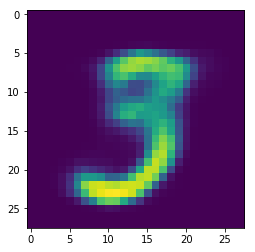

In [290]:
a = td_mod1.predict(td_x_train[0:1])
imshow(a[0][0])